# MNIST

Kézzel írt számjegyek, és sok más ehhez hasonló szerkezetű adathalmaz, pl. fashionMNIST

Feladat kategorizálni a képeket az ábrázolt számjegy alapján.

In [1]:
try:
    import tensorflow_datasets as tfds
except ModuleNotFoundError:
    ! pip install  tensorflow-datasets tensorflow

In [2]:
from tqdm.auto import tqdm

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

ds = tfds.load('mnist', split='train', shuffle_files=False)
print(len(ds))



2024-12-11 13:04:01.627520: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 13:04:01.721405: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 13:04:01.798649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733918641.872867   26678 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733918641.894056   26678 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 13:04:02.068206: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

60000


2024-12-11 13:04:05.542738: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
train = ds.take(50_000).cache()
test = ds.skip(50_000).take(10_000).cache()
len(train), len(test)

(50000, 10000)

In [5]:

example = next(iter(train.batch(64).take(1).as_numpy_iterator()))
image, label = example['image'], example['label']

2024-12-11 13:04:05.714824: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2024-12-11 13:04:05.740042: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-12-11 13:04:05.740134: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `datas

(8, 8, 28, 28)


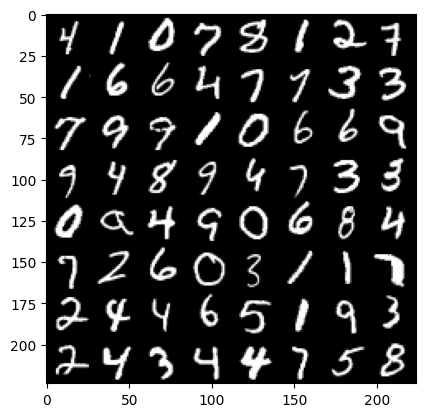

[[4 1 0 7 8 1 2 7]
 [1 6 6 4 7 7 3 3]
 [7 9 9 1 0 6 6 9]
 [9 4 8 9 4 7 3 3]
 [0 9 4 9 0 6 8 4]
 [7 2 6 0 3 1 1 7]
 [2 4 4 6 5 1 9 3]
 [2 4 3 4 4 7 5 8]]


In [6]:
import matplotlib.pyplot as plt
import numpy as np

img0 = image[:64].reshape(8,8,28,28)
print(img0.shape)
img0 = np.transpose(img0, axes=(0,2,1,3)).reshape(8*28, 8*28)
plt.imshow(img0, cmap="gray")
plt.show()
print(label[:64].reshape(8,8))

In [7]:
image.shape, label.shape

((64, 28, 28, 1), (64,))

## Feladat: Kategorizáljuk a képeket
## Hogyan lehet ilyesmit leprogramozni?

Az első ötletünk az lehet, hogy próbáljuk megérteni, mitől érzékelünk egy képet 1-esnek, 2-esnek, stb. majd ezt valahogy formalizáljuk végül lekódoljuk.

Ez teljesen reménytelennek tűnik. Ehelyett inkább olyan eljárást keresünk, ami egy könnyen számolható függvény osztályból kiválaszt egyet, ami az esetek többségében jól működik.

#### Milyen függvény osztályok jöhetnek szóba?

A függvény bemenete egy kép, jelen esetben szürkeárnyalatos 28x28 pixeles kép. Azaz minden bemenet 28x28 intenzitás értékkel van megadva.
Erre gondolhatunk úgy, hogy egy 784 dimenziós (valós) vektorra.


Mi lenne a függvény kimenete? 10 lehetséges kategória (osztály) között kell választani. Ezért a kimenet lehetne egy egész 0 és 9 között, de egyszerűbb 10 értéket kiszámolni és aztán a döntés a legnagyobb érték indexe.  

Azaz keresünk egy
$$
    g:\mathbb{R}^{784} \to \mathbb{R}^{10}, \quad f = \arg\max(g)
$$

A legegyszerűbb függvények a lineáris függvények, ezek könnyen paraméterezhetőek.

Általában is függvény osztály elemeit paraméteresen adjuk meg és a paramétereket szeretnénk azonosítani.


## Paraméterek keresése, veszteség minimalizálás

Mikor gondolnánk egyik függvényt jobbnak mint a másikat? Nyilván akkor, ha több helyest döntést hoz. Azaz $g_0(x_i),\dots,g_9(x_i)$ értékek
közül az esetek többségében az $y_i$ indexű a legnagyobb, ahol $(x_i,y_i)$ az ismert input-output párokat jelöli.

Egy lehetséges kritérium, hogy az $y_i$ indexet 0-1 vektorként kódoljuk $z_i=(\mathbb{1}_{k=y_i})_{k=0}^9$ és olyan $g$-t keresünk, amire
$$
    \sum_i \|g(x_i) - z_i\|^2
$$
minimális.

Egy másik lehetőség lehetne, hogy a
$$
    \sum_i \sum_k (2z_{i,k}-1)*g_k(x_i)
$$
kifejezést próbálnánk maximalizálni. Ezzel az a gond, hogy felülről nem feltétlenül korlátos.

Egy további lehetőség lehetne, hogy a
$$
    \sum_i \sum_k \max(1-(2z_{i,k}-1)*g_k(x_i),0)
$$
minimalizálása, vagy
$$
    \sum_i -\log p_{y_i}(x_i), \quad p_k(x)=\frac{e^{g_k(x)}}{\sum_\ell e^{g_\ell(x)}}
$$
minimalizálása.

Ezekben az a közös, hogy megfogalmazhatóak egy ($x$-ben differenciálható) veszteség minimalizálásaként.


## Gradiens ereszkedés (Gradient descent)
Néhány esetben a megoldás kifejezhető az $(x_i, y_i)$ párok segítségével, de még ezekben az esetekben is inkább általános iterative eljárást szoktak használni.

A $g(x)$ valójában $g(x,\vartheta)$, ahol $\vartheta$ a függvény megadására szolgáló paraméter vektor. pl. ha $g$ lineáris, akkor
$$
    g(x) = b + Ax,\quad \vartheta=(b, A),\quad b\in\mathbb{R}^{10},\quad A\in\mathbb{R}^{10\times 784}, \quad x\in\mathbb{R}^{784}
$$

Azaz $g$ a paraméter szerint is deriválható. Ha $\ell$ jelöli a veszteség függvényt, akkor
$$
    \hat\vartheta = \arg\min_{\theta}L(\vartheta), \quad L(\vartheta) = \frac1n\sum_{i} \ell (g(x_i,\vartheta), y_i)
$$
úgy is számolható, hogy
$$
    \vartheta_{n+1} = \vartheta_n -\eta L'(\vartheta_n)
$$
ahol $\eta$ általában egy kicsi szám, a tanulási ráta. Mindig abba az irányba próbáljuk $\vartheta_n$-t módosítani amerre a leginkább csökken.
Ezt a minimalizálási eljárást gradiens ereszkedésnek hívják.

Gyakran nem kell $L'$-t pontosan számolni elegendő az adatok egy $b$ részét használni, Azaz $L'$ helyett $L'_b$-t használjuk, ahol
$$
    L'_b(\vartheta)=\frac{1}{|b|}\sum_{i\in b} \partial_\vartheta\ell(g(x_i, \vartheta), y_i)
$$

Szerencsére a derivált számolást nem kell leprogramozni. A neurális hálós keretrendszerek mind megteszik ezt nekünk. Mi a `jax` könytárat fogjuk használni.



In [8]:
try:
    import jax
except ModuleNotFoundError:
    ! pip install jax[cpu]


In [9]:
from jax import grad
import jax.numpy as jnp

def tanh(x):  # Define a function
  y = jnp.exp(-2.0 * x)
  return (1.0 - y) / (1.0 + y)

grad_tanh = grad(tanh)  # Obtain its gradient function
print(grad_tanh(1.0))   # Evaluate it at x = 1.0
# prints 0.4199743

0.4199743


In [10]:
import jax
import jax.numpy as jnp

In [11]:
def g(theta, x):
    x = x.reshape(-1)
    b, A = theta
    return b + A @ x

def f(g):
    return g.argmax()

theta = np.random.normal(size=10), np.random.normal(size=(10, 784))

In [12]:
x = image[0]
pred = g(theta, x)
print(f'{pred}\nA képen {f(pred)} van?')

[ -843.74122608  -873.42024148 -1629.07407432   472.91045136
 -1052.08674973 -1147.60655164   775.53553623 -1406.33411966
 -1014.13438582 -1697.14032177]
A képen 6 van?


Szerencsésebb lenormálni az $A$ mátrixot, és a képet is.

In [13]:
image[0].max()

255

In [14]:
def g(theta, x):
    x = x.reshape(-1)/255
    b, A = theta
    return b + A @ x

def f(g):
    return g.argmax()

theta = np.random.normal(size=10), (784**(-0.5))*np.random.normal(size=(10, 784))

[-1.24448938  0.81623145  1.23961001 -0.46572317  0.458576    0.25289278
  0.43823394  0.37492673  2.29382692 -0.40963398]
A képen 8 van?


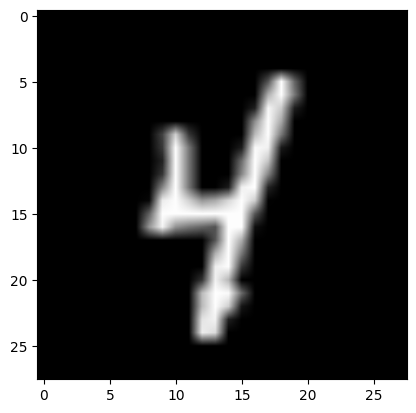

In [15]:

x = image[0]
pred = g(theta, x)
print(f'{pred}\nA képen {f(pred)} van?')
plt.imshow(x.squeeze(), cmap='gray', interpolation='bilinear')

## Veszteség függvény

Válasszuk a keresztentrópiát:
$$
    \sum_i -\log p_{y_i}(x_i)=\sum -g_{y_i}(x_i)+\log(\sum_je^{g_j(x_i)}), \quad p_k(x)=\frac{e^{g_k(x)}}{\sum_j e^{g_j(x)}}
$$

In [16]:
def ell(pred, y):
    return jax.nn.log_softmax(pred) @ y

def ell(pred, y):
    return -pred@y + jax.nn.logsumexp(pred)


In [17]:
y = jax.nn.one_hot(label[0], 10)
pred = g(theta, x)
log_p = jax.nn.log_softmax(pred)
print(f'pred: \t{pred}\none-hot:\t{y}\nlog p:\t{log_p}\nloss:\t{ell(pred, y)}')

pred: 	[-1.24448938  0.81623145  1.23961001 -0.46572317  0.458576    0.25289278
  0.43823394  0.37492673  2.29382692 -0.40963398]
one-hot:	[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
log p:	[-4.38359    -2.3228695  -1.8994911  -3.6048243  -2.680525   -2.8862083
 -2.700867   -2.7641742  -0.84527415 -3.548735  ]
loss:	2.680525064468384


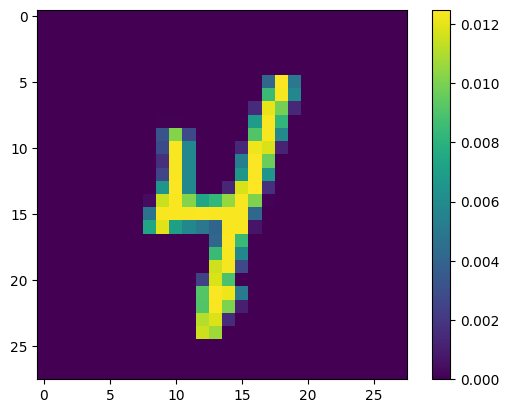

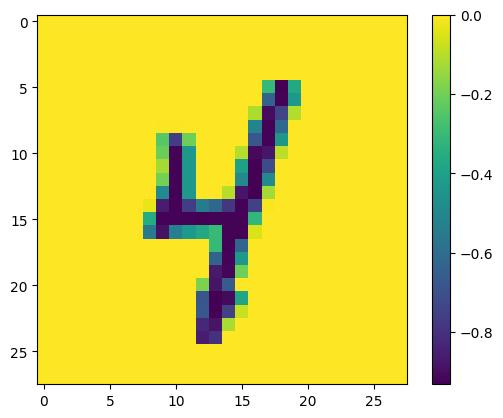

In [18]:
def L(theta, x, y):
    pred = g(theta, x)
    return ell(pred, y)

dL = grad(L)

dx, dA = dL(theta, x, y)

plt.imshow(dA[0].reshape(28,28))
plt.colorbar()
plt.show()

plt.imshow(dA[4].reshape(28,28))
plt.colorbar()
plt.show()

In [19]:
batch_L = jax.vmap(L, in_axes=None)
batch_L(theta, x=image[:16]/255, y=jax.nn.one_hot(label[:16], 10))


Array([2.6485503, 2.493639 , 3.8831868, 2.5506883, 1.1224648, 2.49349  ,
       1.5845561, 2.5519214, 2.494263 , 2.24018  , 2.238824 , 2.6481729,
       2.551902 , 2.550715 , 3.49569  , 3.4957151], dtype=float32)

In [20]:
def loss_fn(theta, x, y):
    return batch_L(theta, x=x, y=y).mean(axis=0)

loss_fn = jax.value_and_grad(loss_fn)

def training_step(theta, x, y, eta):
    y = jax.nn.one_hot(y, 10)
    loss, gradient = loss_fn(theta, x=x, y=y)
    return loss, jax.tree_map(lambda t, g: t-eta*g, theta, gradient)

In [21]:
# loss_fn(theta, x=image[:16]/255, y=jax.nn.one_hot(label[:16], 10))
loss, gradient = training_step(theta, x=image[:16], y=label[:16], eta=0.1)

In [22]:
gradient

(Array([-0.9421983 ,  0.44624165,  1.3363031 , -0.55266327,  0.28928393,
         0.05437301,  0.7006462 ,  0.4009034 ,  1.7820284 , -0.7740788 ],      dtype=float32),
 Array([[ 0.0646008 , -0.00186514,  0.03109545, ...,  0.04946698,
          0.04307408, -0.01379584],
        [ 0.02497304,  0.00665963, -0.01815902, ...,  0.08088779,
          0.00943177,  0.08674561],
        [-0.01622147, -0.09854695, -0.0321921 , ..., -0.01335777,
          0.11398099, -0.06356982],
        ...,
        [ 0.0358687 ,  0.09679822, -0.01792891, ...,  0.01139084,
         -0.01212531, -0.02100479],
        [-0.04894619, -0.00819712, -0.01967735, ...,  0.03587451,
          0.01504151,  0.0579158 ],
        [-0.0378418 , -0.06667421,  0.01166095, ..., -0.03325006,
          0.03826747, -0.04614054]], dtype=float32))

In [23]:
theta = theta = 0.1 * np.random.normal(size=10), (784**(-0.5))*np.random.normal(size=(10, 784))
eta = 0.1
losses = []

for i, example in tqdm(enumerate(train.repeat().shuffle(10000).batch(256).take(2000).as_numpy_iterator())):
    img, label = example['image'], example['label']
    loss, theta = training_step(theta, img, label, eta)
    losses.append(loss)
    if (i+1) % 200==0:
        eta *= 0.5

0it [00:00, ?it/s]

2024-12-11 13:04:12.334512: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-12-11 13:04:43.191014: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [24]:
eta

9.765625e-05

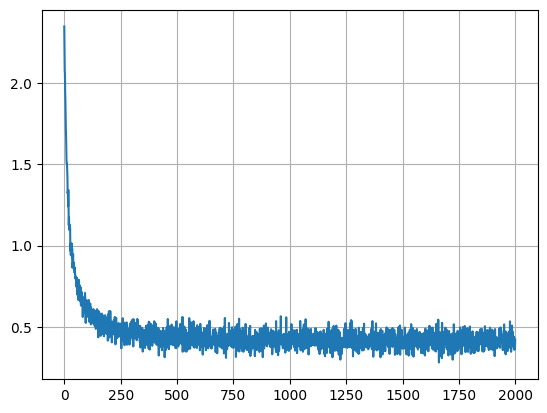

In [25]:
plt.plot(losses)
plt.grid()
plt.show()

In [26]:
def predict(theta, x):
    return jax.vmap(g, in_axes=None)(theta, x=x).argmax(axis=1)

In [27]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def cm_(y_true, y_pred, classes=None):
    if classes is None:
        classes = np.unique(y_true)
    cm = pd.DataFrame(
        confusion_matrix(
            y_pred=y_pred,
            y_true=y_true,
            labels=classes
            ),
            columns=classes,
            index=classes)
    cm.index.name = 'True'
    cm.columns.name = 'Predicted'
    return cm


In [28]:
preds = []
labels = []
for example in test.batch(256).as_numpy_iterator():
    img, label = example['image'], example['label']
    preds.append(predict(theta, x=img))
    labels.append(label)
preds = np.concatenate(preds)
labels = np.concatenate(labels)
print('test tévesztési mátrix')
cm_(y_pred=preds, y_true=labels)
#confusion_matrix(y_pred=preds, y_true=label, labels=range(10))

test tévesztési mátrix


2024-12-11 13:04:45.601535: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,910,0,6,3,1,12,10,1,15,1
1,1,1091,7,7,1,6,0,3,12,1
2,8,11,866,11,25,2,20,23,29,4
3,7,4,22,893,1,33,4,10,27,16
4,2,8,11,0,900,3,10,1,8,44
5,22,12,9,40,20,721,16,9,45,18
6,4,5,12,3,14,16,927,0,7,0
7,8,19,17,2,16,0,0,959,1,35
8,6,35,21,40,10,20,9,7,802,23


In [29]:
preds = []
labels = []
for example in train.batch(256).as_numpy_iterator():
    img, label = example['image'], example['label']
    preds.append(predict(theta, x=img))
    labels.append(label)
preds = np.concatenate(preds)
labels = np.concatenate(labels)
print('train tévesztési mátrix')
cm_(y_pred=preds, y_true=labels)


train tévesztési mátrix


Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,4752,0,24,17,15,28,54,6,60,8
1,0,5410,26,27,4,40,11,11,74,10
2,53,67,4206,93,106,12,119,110,151,42
3,26,42,132,4396,5,210,44,72,121,66
4,10,28,33,6,4382,6,67,12,39,272
5,93,68,39,215,75,3616,98,32,190,83
6,39,27,61,3,37,79,4626,1,54,3
7,44,80,84,23,79,10,2,4668,22,196
8,26,150,63,164,17,153,46,35,4117,107


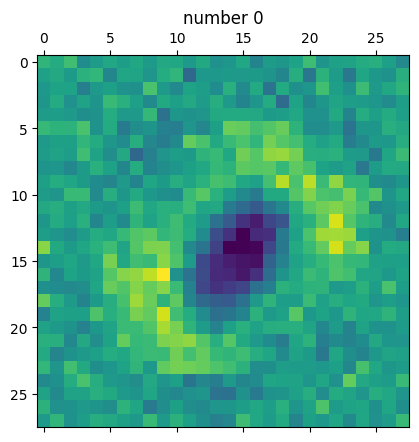

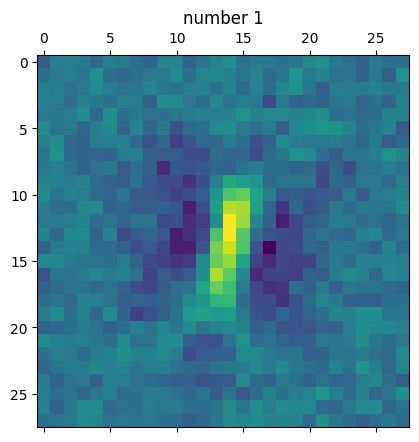

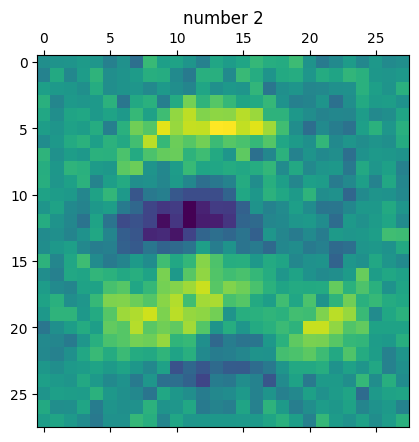

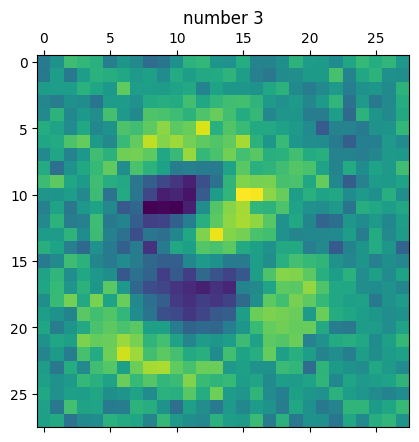

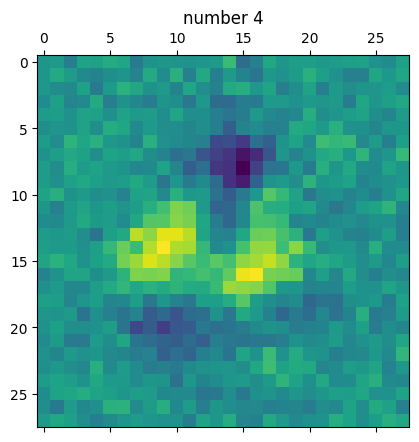

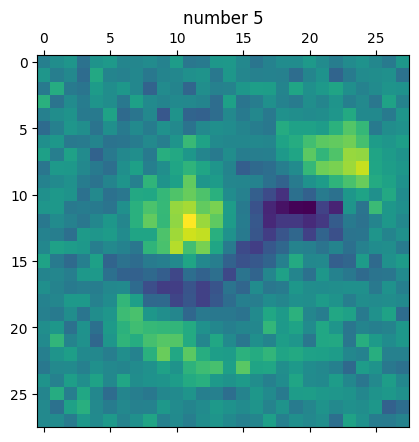

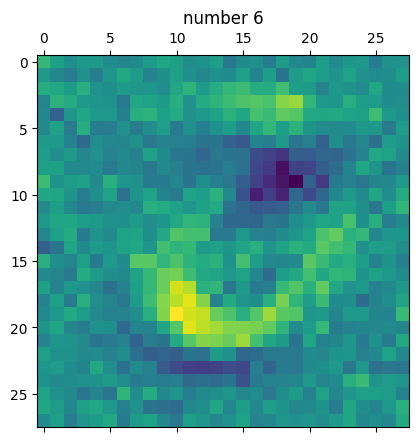

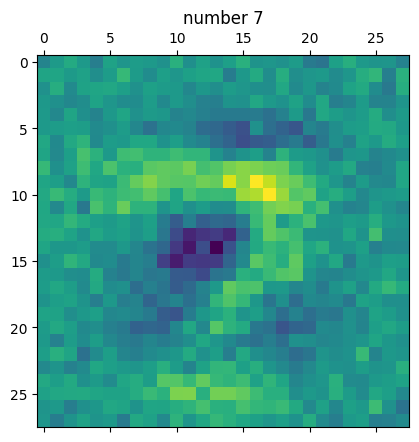

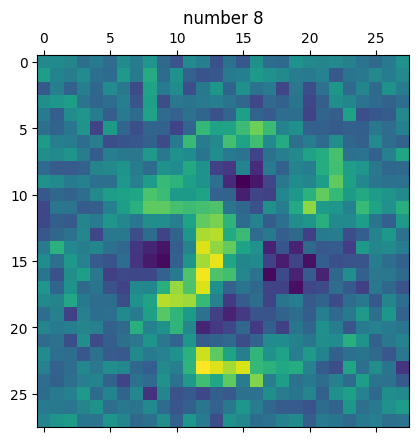

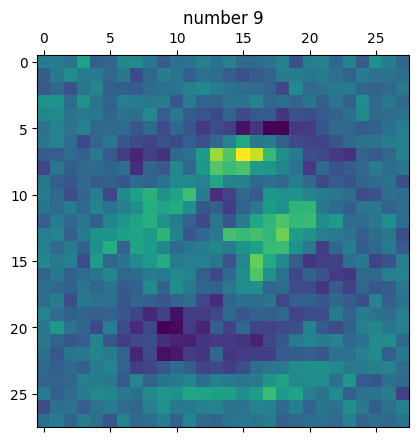

In [55]:
b, A = theta
for i, row in enumerate(A):
    plt.matshow(row.reshape(28, 28)) #, interpolation='bilinear')
    plt.title(f'number {i}')
    plt.show()

## Több rétegű neurális háló

Lineáris függvények családja nagyon szűk.

Az derül ki, hogy ha $g_1\circ \sigma\circ g_2$ alakban már tetszőleges (folytonos) függvény közelíthető, ha a közepső tér dimenziója elég nagy és
$\sigma$ egy koordinátánként számolt nem lineáris **aktivációs** függvény. Szokásos választások $\sigma$-ra $\sigma(x)=\max(x,0)$,  vagy $\sigma(x)=\tanh(x)$, vagy $\sigma(x)=1/(1+e^{-x})$ (mindegyik koordinátánként értendő).

A következő rész a `jax` dokumentációjában szereplő példa.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/main/docs/notebooks/Neural_Network_and_Data_Loading.ipynb)

In [31]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax

A véletlen számokat a `jax` rendszer kicsit másképp kezeli. A véletlenszám generátornak mindig meg kell adni egy kulcsot (a generátor állapotát).
Új véletlenszám generálása előtt a kulcsot szét kell bontani, az egyikből az aktuális érték(ek)et szzámoljuk, a másikból a következőket.

In [32]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
params = init_network_params(layer_sizes, random.PRNGKey(0))

A `predict` függvény hasonló a fentihez, de most minden (rejtett) réteg után alkalmazunk egy `relu` (rectified linear unit, igazából pozitív rész) nem linearitást, vagy aktivációs függvényt.

In [33]:
from jax.scipy.special import logsumexp

def relu(x):
  return jnp.maximum(0, x)

def predict(params, image):
  # per-example predictions
  activations = image.flatten()/255.0
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = relu(outputs)

  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits - logsumexp(logits)

In [34]:
# This works on single examples
preds = predict(params, image[0])
print(preds.shape)
print(preds)

(10,)
[-2.2953994 -2.2987492 -2.2974277 -2.318979  -2.3008723 -2.3090346
 -2.3071167 -2.3012722 -2.3021984 -2.2950432]


Ugyanúgy mint a lineáris esetben a `predict` függvény nem képes több képet egyszerre kezelni.

In [35]:
try:
  preds = predict(params, image[:10])
except TypeError:
  print('Invalid shapes!')

Invalid shapes!


A `vmap` transzformáció most is segít.

In [36]:
batched_predict = vmap(predict, in_axes=(None, 0))

batched_preds = batched_predict(params, image[:8])
print(batched_preds.shape)

(8, 10)


In [37]:
n_targets = 10

In [38]:
def y_pred_true(f, params, dataset):
    y_pred = []
    y_true = []
    for example in tqdm(dataset.batch(256).as_numpy_iterator()):
        images, targets = example['image'], example['label']
        y_pred.append(f(params, images).argmax(axis=-1))
        y_true.append(targets)
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    return {'y_pred': y_pred, 'y_true':y_true}

def accuracy(f, params, dataset):
    y = y_pred_true(f, params, dataset)
    acc = sum(y['y_pred'] == y['y_true'])
    n = len(y['y_pred'])
    return acc/n

def loss(params, images, targets):
    targets = jax.nn.one_hot(targets, n_targets)
    preds = batched_predict(params, images)
    return -jnp.mean(preds * targets)*n_targets

@jit
def update(params, x, y):
    grads = grad(loss)(params, x, y)
    return jax.tree_map(lambda p, g: p - step_size * g, params, grads)


Konstansok:

In [39]:
step_size = 0.1
num_epochs = 8
batch_size = 128


In [40]:
import time

lr = jnp.array(step_size)
for epoch in range(num_epochs):
  start_time = time.time()
  for example in tqdm(train.shuffle(5000).batch(128).as_numpy_iterator()):
    x, y = example['image'], example['label']
    params = update(params, x, y)
  epoch_time = time.time() - start_time

  train_acc = accuracy(batched_predict, params, train)
  test_acc = accuracy(batched_predict, params, test)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

0it [00:00, ?it/s]

2024-12-11 13:04:51.926257: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 0 in 2.23 sec
Training set accuracy 0.85938
Test set accuracy 0.8625


0it [00:00, ?it/s]

0it [00:00, ?it/s]

2024-12-11 13:05:00.993238: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


0it [00:00, ?it/s]

Epoch 1 in 1.84 sec
Training set accuracy 0.90504
Test set accuracy 0.9049


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 2 in 1.85 sec
Training set accuracy 0.9257
Test set accuracy 0.9196


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 3 in 1.95 sec
Training set accuracy 0.94522
Test set accuracy 0.9397


0it [00:00, ?it/s]

2024-12-11 13:05:14.173070: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 4 in 1.68 sec
Training set accuracy 0.95868
Test set accuracy 0.9538


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 5 in 1.62 sec
Training set accuracy 0.9634
Test set accuracy 0.9546


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 6 in 1.64 sec
Training set accuracy 0.96904
Test set accuracy 0.9629


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 7 in 1.64 sec
Training set accuracy 0.9713
Test set accuracy 0.9613


In [41]:
train_y = y_pred_true(batched_predict, params, train)
cm_(train_y['y_pred'], train_y['y_true'])

0it [00:00, ?it/s]

Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,4859,0,12,2,1,5,13,1,5,9
1,1,5540,28,3,8,3,9,15,27,6
2,4,4,4611,8,0,1,0,9,0,0
3,14,24,158,4986,4,40,1,13,45,32
4,2,6,17,0,4755,7,22,23,12,62
5,20,2,6,53,6,4407,68,5,33,22
6,15,1,10,0,14,6,4792,0,3,0
7,6,7,44,19,4,2,0,5099,2,36
8,34,22,65,30,4,26,25,8,4729,16


In [42]:
test_y = y_pred_true(batched_predict, params, test)
cm_(test_y['y_pred'], test_y['y_true'])

0it [00:00, ?it/s]

Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,929,1,1,0,1,4,5,1,1,0
1,0,1101,10,0,2,0,4,1,11,2
2,0,6,908,3,1,1,0,5,0,0
3,2,6,36,990,1,10,0,6,15,8
4,1,2,5,1,967,3,13,2,5,18
5,5,0,0,7,1,881,12,1,6,5
6,4,0,4,0,3,1,947,0,1,0
7,0,6,16,4,2,2,0,1033,2,9
8,13,6,18,6,0,4,7,0,925,5


## Konvolúciós háló

Az ötlet az, hogy a kép kis részeit tekintsük, pl. az összes 5*5-ös részképet és mindegyikre ugyanazt a lineáris leképezést alkalmazzuk, majd az eredményekre az aktivációs függvényt. Ezzel kapunk egy másik (gyakran kisebb) képet ahol, nem 1 vagy 3 ,,szín'' van, hanem sok, attól függően, hogy hány ismérvet számolunk ki a kis képből. Ezzel a kép lokális tulajdonságait lehet kigyűjteni (van vonal vagy nincs, annak az iránya stb). Ilyen rétegeket pakolunk egymásra és a végén a kapott képre az imént látott összegzést alkalmazzuk.



In [43]:
try:
    import haiku as hk
except ModuleNotFoundError:
    ! pip install dm-haiku

In [44]:
hk.MaxPool?

Init signature:
hk.MaxPool(
    window_shape: Union[int, collections.abc.Sequence[int]],
    strides: Union[int, collections.abc.Sequence[int]],
    padding: str,
    channel_axis: Optional[int] = -1,
    name: Optional[str] = None,
)
Docstring:     
Max pool.

Equivalent to partial application of :func:`max_pool`.
Init docstring:
Max pool.

Args:
  window_shape: Shape of the pooling window, same rank as value.
  strides: Strides of the pooling window, same rank as value.
  padding: Padding algorithm. Either ``VALID`` or ``SAME``.
  channel_axis: Axis of the spatial channels for which pooling is skipped.
  name: String name for the module.
File:           ~/.config/jupyterlab-desktop/jlab_server/envs/python3.10/lib/python3.10/site-packages/haiku/_src/pool.py
Type:           ModuleMetaclass
Subclasses:     


In [45]:
hk.transform?

Signature: hk.transform(f, *, apply_rng=True) -> haiku._src.transform.Transformed
Docstring:
Transforms a function using Haiku modules into a pair of pure functions.

For a function ``out = f(*a, **k)`` this function returns a pair of two pure
functions that call ``f(*a, **k)`` explicitly collecting and injecting
parameter values::

    params = init(rng, *a, **k)
    out = apply(params, rng, *a, **k)

Note that the ``rng`` argument is typically not required for ``apply`` and
passing ``None`` is accepted.

The first thing to do is to define a :class:`Module`. A module encapsulates
some parameters and a computation on those parameters:

>>> class MyModule(hk.Module):
...   def __call__(self, x):
...     w = hk.get_parameter("w", [], init=jnp.zeros)
...     return x + w

Next, define some function that creates and applies modules. We use
:func:`transform` to transform that function into a pair of functions that
allow us to lift all the parameters out of the function (``f.init``) and
appl

In [46]:
def lenet(x):
    x = x.astype(jnp.float32)/255
    x = hk.Conv2D(32, 5, padding='VALID')(x)
    x = jax.nn.relu(x)
    x = hk.MaxPool(2, 2, padding='VALID')(x)
    x = hk.Conv2D(64, 5, padding='VALID')(x)
    x = jax.nn.relu(x)
    x = hk.MaxPool(2, 2, padding='VALID')(x)
    x = hk.Flatten()(x)
    x = hk.Linear(128)(x)
    x = jax.nn.relu(x)
    x = hk.Linear(n_targets)(x)
    x = jax.nn.log_softmax(x)
    return x


In [47]:
param_init, lenet_apply = hk.transform(lenet)
def lenet_fn(params, images):
    return lenet_apply(params, None, images)

In [48]:
key = jax.random.PRNGKey(0)
params = param_init(key, image[:10])

In [49]:
lenet_apply(params, None, image[:1])

Array([[-2.4083664, -2.1603966, -2.3317041, -2.5491571, -2.2276087,
        -2.2106547, -2.1173048, -2.474362 , -2.3706279, -2.2626748]],      dtype=float32)

In [50]:

def lenet_loss(params, images, targets):
  targets = jax.nn.one_hot(targets, n_targets)
  preds = lenet_apply(params, None, images)
  return -jnp.mean(preds * targets)*n_targets

@jit
def lenet_update(params, x, y, step_size):
  grads = grad(lenet_loss)(params, x, y)
  return jax.tree_map(lambda p, g: p - step_size * g, params, grads)


In [51]:
import time

lr = jnp.array(step_size)

for epoch in range(num_epochs):
  start_time = time.time()
  for example in tqdm(train.cache().shuffle(5000).batch(128).as_numpy_iterator()):
    x, y = example['image'], example['label']
    params = lenet_update(params, x, y, lr)
  lr = lr*0.9
  epoch_time = time.time() - start_time

  train_acc = accuracy(lenet_fn, params, train)
  test_acc = accuracy(lenet_fn, params, test)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 0 in 37.12 sec
Training set accuracy 0.9683
Test set accuracy 0.9669


2024-12-11 13:06:26.839766: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 1 in 35.55 sec
Training set accuracy 0.9805
Test set accuracy 0.9745


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 2 in 35.86 sec
Training set accuracy 0.98628
Test set accuracy 0.9798


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 3 in 36.64 sec
Training set accuracy 0.9888
Test set accuracy 0.9822


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 4 in 35.41 sec
Training set accuracy 0.99128
Test set accuracy 0.9853


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 5 in 36.51 sec
Training set accuracy 0.99216
Test set accuracy 0.9865


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 6 in 34.50 sec
Training set accuracy 0.99318
Test set accuracy 0.986


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 7 in 34.81 sec
Training set accuracy 0.99416
Test set accuracy 0.9869


In [52]:
train_y = y_pred_true(lenet_fn, params, train)
cm_(train_y['y_pred'], train_y['y_true'])

0it [00:00, ?it/s]

Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,4955,0,0,4,0,1,4,0,2,8
1,1,5599,3,0,6,2,1,9,10,4
2,3,4,4942,13,0,2,1,8,7,0
3,0,0,0,5058,0,6,0,0,1,1
4,0,0,2,1,4840,0,2,2,2,22
5,0,0,0,10,0,4474,4,0,2,6
6,3,1,1,1,2,16,4916,0,4,1
7,1,7,9,14,3,1,0,5183,3,18
8,0,2,1,10,1,6,2,5,4841,10


In [53]:
test_y = y_pred_true(lenet_fn, params, test)
cm_(test_y['y_pred'], test_y['y_true'])

0it [00:00, ?it/s]

Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,953,0,0,0,0,2,1,1,1,2
1,0,1116,4,0,1,0,0,1,1,0
2,0,4,984,4,2,0,1,3,3,0
3,0,0,2,1005,0,5,0,0,4,2
4,1,1,0,0,975,0,2,1,1,7
5,0,0,0,2,0,896,1,0,2,1
6,2,0,0,0,3,5,982,0,3,0
7,0,6,4,0,1,2,0,1048,2,6
8,2,2,5,2,2,2,1,0,952,3
